In [1]:
from urllib.request import urlopen
from json import loads
import pandas as pd
from itertools import chain
from dask import bag
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
drink_df = pd.read_csv('../Data/all_drinks.csv')
drink_df.sample(3)

,Unnamed: 0,strDrink,dateModified,idDrink,strAlcoholic,strCategory,strDrinkThumb,strGlass,strIBA,strIngredient1,...,strMeasure15,strMeasure2,strMeasure3,strMeasure4,strMeasure5,strMeasure6,strMeasure7,strMeasure8,strMeasure9,strVideo
442,442,Rum Screwdriver,2017-09-08 16:59:32,12091,Alcoholic,Ordinary Drink,http://www.thecocktaildb.com/images/media/drin...,Highball glass,NaN,Light rum,...,NaN,5 oz,,,,,,NaN,NaN,NaN
167,167,Brandy Alexander,2017-01-02 20:09:06,11016,Alcoholic,Ordinary Drink,http://www.thecocktaildb.com/images/media/drin...,Cocktail glass,NaN,Brandy,...,NaN,1 oz white,1 oz,\n,\n,\n,\n,\n,\n,NaN
411,411,Poppy Cocktail,2017-09-02 23:05:15,11959,Alcoholic,Ordinary Drink,http://www.thecocktaildb.com/images/media/drin...,Cocktail glass,NaN,Gin,...,NaN,3/4 oz white,,,,,,NaN,NaN,NaN


In [6]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(analyzer = 'char_wb')
cv.fit(drink_df['strDrink'].values)
new_vocab_dict = {id: word for word,id in cv.vocabulary_.items()}

In [7]:
cv_mat = cv.transform(drink_df['strDrink'].values)

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [9]:
str_vec = drink_df['strDrink'].str.lower()
MAX_NB_WORDS, MAX_SEQUENCE_LENGTH = 5000, 30
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, char_level=True)
tokenizer.fit_on_texts(str_vec)
train_sequences = tokenizer.texts_to_sequences(str_vec)
train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 47 unique tokens.


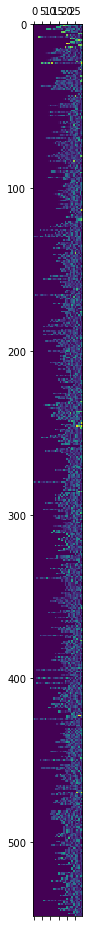

In [10]:
plt.matshow(train_data)

In [11]:
def isempty(x):
    try:
        if x is None: 
            return True
        elif len(x)<1:
            return True
        else:
            return False
    except:
        # floating point nans
        return True
all_ingred = drink_df[[x for x in drink_df.columns 
                       if 'Ingredient' in x]].apply(lambda c_row: [v.lower() for k,v in c_row.items() if not isempty(v)],1)
all_ingred[0:3]

0                              [creme de cacao, vodka]
1    [absolut kurant, grand marnier, chambord raspb...
2                                     [lager, tequila]
dtype: object

In [12]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
ingred_label = LabelEncoder()
ingred_label.fit(list(chain(*all_ingred.values)))
print('Found', len(ingred_label.classes_), 'unique ingredients, ', ingred_label.classes_[0:3])

Found 308 unique ingredients,  ['151 proof rum' '7-up' 'absinthe']


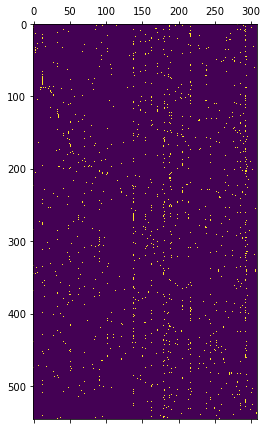

In [13]:
y_vec = np.stack(all_ingred.map(lambda x: np.sum(to_categorical(ingred_label.transform(x), 
                                        num_classes=len(ingred_label.classes_)),0)),0).clip(0,1)
plt.matshow(y_vec)

In [14]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
train_idx, test_idx = train_test_split(range(y_vec.shape[0]), 
                                                    random_state = 12345,
                                                   train_size = 0.7)
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(cv_mat[train_idx], y_vec[train_idx])
pred_vec = rf.predict(cv_mat[test_idx])

print('Mean Error %2.2f%%' % (100*mean_absolute_error(y_vec[test_idx], pred_vec)))

Mean Error 2.37%


In [59]:
pred_vec('test')

TypeError: 'numpy.ndarray' object is not callable